# Image Compression #

We can use clustering as a means to compress images. But it's going to work a little differently than what you are used to: Instead of guessing at the number of clusters, we purposely choose the k-value depending on how much compression we desire. The lower the k-value, the higher the compression but the more distorted the picture. The higher the k-value, the lower the compression but the picture will look closer to the original. We'll be using k-values of 16 and 256. I chose these two numbers because we can represent 16 clusters with 4 bits and 256 clusters with 8 bits.

The clustering algorithm will give us a palette of RGB colors that "represent" the overall image. So for the 16 cluster algorithm, we'll have 16 colors in our palette. These palette colors are actually the centroids from the algorithm. Once KMeans chooses the color palette for us, we'll replace the original pixels with these representative values (e.g., the identity of their cluster).

We'll go ahead and use the SKLearn version of KMeans as our clustering algorithm. If you'd like to substitute your own version of KMeans, that's OK too although it will probably be slower.

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from matplotlib.image import imread
import matplotlib.pyplot as plt

## Preprocessing ##

Load the image file from disk and reshape it from a 2D dataset of RGB pixels to a really long sequence of RGB pixels one after the other. Basically, we're going to tack the second row to the end of the first row, the third row to the end of the second row, the fourth row to the end of the third row, and so on for the entire image.

In [2]:
#IMAGE_FILE = 'lydia.bmp'
IMAGE_FILE = 'sample_photos/elizabeth.bmp'

# Read the file from disk
img = imread(IMAGE_FILE)
print(img)
print("\nnumpy shape = {}".format(img.shape))

(height, width, depth) = img.shape
print("Height = {} pixels".format(height))
print("Width = {} pixels".format(width))
print("Depth = {} bytes".format(depth))

[[[245 247 246]
  [244 246 245]
  [244 246 245]
  ...
  [131 128 111]
  [132 129 112]
  [133 130 113]]

 [[244 246 245]
  [244 246 245]
  [244 246 245]
  ...
  [135 132 115]
  [136 133 116]
  [137 134 117]]

 [[244 246 245]
  [244 246 245]
  [244 246 245]
  ...
  [139 136 117]
  [139 136 117]
  [141 138 119]]

 ...

 [[138 137  91]
  [139 138  92]
  [140 139  93]
  ...
  [200 189 157]
  [196 186 151]
  [193 183 148]]

 [[141 140  92]
  [143 142  94]
  [144 143  95]
  ...
  [195 187 151]
  [192 184 148]
  [190 182 146]]

 [[144 143  95]
  [146 145  97]
  [148 147  99]
  ...
  [192 184 148]
  [190 182 146]
  [189 181 145]]]

numpy shape = (600, 700, 3)
Height = 600 pixels
Width = 700 pixels
Depth = 3 bytes


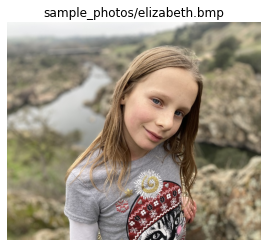

In [3]:
# Double check that we have the right image
plt.title(IMAGE_FILE)
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
# Convert image from HxWxD array to just a long list of pixel values
print("before reshape = {}".format(img.shape))
X = img.reshape(width * height, depth)
print(" after reshape = {}".format(X.shape))

before reshape = (600, 700, 3)
 after reshape = (420000, 3)


In [5]:
# Show that the rows are just placed one after the other
# NOTE:This assumes an image that is 700 pixels wide
print("Before:")
print(img[0][-2], img[0][-1], img[1][0], img[1][1])
print()
print("After:")
print(X[698], X[699], X[700], X[701])

Before:
[132 129 112] [133 130 113] [244 246 245] [244 246 245]

After:
[132 129 112] [133 130 113] [244 246 245] [244 246 245]


## Compress the Data ##

The KMeans Algorithm will cluster the individual pixels and give us $k$ representative colors that are somewhat similar to the individual samples (pixel colors) in the cluster. The centroids will be our new (compressed) RGB values and the labels will identify each pixel and which compressed color represents it.

In [6]:
NUMBER_OF_COLORS = 16
KMEANS_RUNS = 5

# Runs the KMeans algorithm multiple times and select the best cluster score
km = KMeans(n_clusters=NUMBER_OF_COLORS, n_init=KMEANS_RUNS)
km.fit(X)
print("Palette Identified")

Palette Identified


In [7]:
# The new pixel values are just the cluster IDs
pixels = km.labels_.astype(np.uint8)
print("Compressed Pixels:  {} {} ... {} {}".format(pixels[0], pixels[1], pixels[-2], pixels[-1]))

# We need to store the original RGB colors of each pixel
# This "color palette" will map cluster IDs back to the correct RGB colors
# Since the RGB values come from our KMeans centroids, they are float values
# that must be converted to integers: round then truncate for accuracy
palette = np.round(km.cluster_centers_, 0).astype(np.uint8)
print("This Color Palette: {} {} ... {} {}".format(palette[0], palette[1], palette[-2], palette[-2]))

Compressed Pixels:  5 5 ... 6 6
This Color Palette: [156 143 115] [67 41 29] ... [192 191 189] [192 191 189]


At this point we have finished the compression algorithm. But before moving on, let's explore and analyze...

### Exploring the Compressed Data ###

The original data contained pixels that were defined by three 8-bit numbers (R, G, and B). We've used KMeans to select 16 representative colors. This means we'll have taken 3 x 8-bit numbers (24 bits) and compressed it down to a single 4-bit number. That's approximately a compression ratio of $24:4 \rightarrow 5:1$.

We say *approximately* the compression ratio instead of *exactly* the compression ratio becuase in addition to storing the 4-bit pixel values, we also have to store the full RGB values for the 16 colors in the palette. But this factor is negligible.

In [8]:
# original first 5 pixels
print("Original Data")
print(img[0][0:5])

# First 5 pixels with their new representative
print("\nCompressed Data")
print(pixels[:5])

print("\nWhat is compressed color #{}?".format(pixels[0]))
print(palette[pixels[0]])

Original Data
[[245 247 246]
 [244 246 245]
 [244 246 245]
 [244 246 245]
 [244 246 245]]

Compressed Data
[5 5 5 5 5]

What is compressed color #5?
[240 239 239]


In [9]:
print("Here are all the colors:")
print(palette)

Here are all the colors:
[[156 143 115]
 [ 67  41  29]
 [214 213 212]
 [117 110  91]
 [171 169 166]
 [240 239 239]
 [202 176 149]
 [106  93  71]
 [231 199 170]
 [131 128 120]
 [138 125  98]
 [ 27  16  10]
 [150 148 146]
 [ 86  71  54]
 [192 191 189]
 [176 158 132]]


### Viewing the Color Palette ###

Just for fun, let's see what the 16 representative colors look like. We'll create an 8x2 plot where each plot shows a 100x100 solid block of color.

In [10]:
# Let's try creating a 100x100 block and see what it looks like
block = np.full([100, 100, 3], palette[0])
block[0][:5]

array([[156, 143, 115],
       [156, 143, 115],
       [156, 143, 115],
       [156, 143, 115],
       [156, 143, 115]], dtype=uint8)

In [11]:
# That worked, so now let's create 32 of these blocks, one for each color in our palette
blocks = [np.full([100, 100, 3], color) for color in palette]
for i in range(5):
    print("Palette Color #{}".format(i))
    print("{}\n".format(blocks[i][0][:3]))

Palette Color #0
[[156 143 115]
 [156 143 115]
 [156 143 115]]

Palette Color #1
[[67 41 29]
 [67 41 29]
 [67 41 29]]

Palette Color #2
[[214 213 212]
 [214 213 212]
 [214 213 212]]

Palette Color #3
[[117 110  91]
 [117 110  91]
 [117 110  91]]

Palette Color #4
[[171 169 166]
 [171 169 166]
 [171 169 166]]



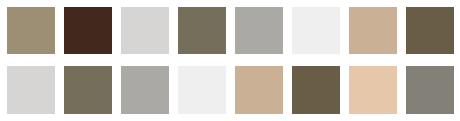

In [12]:
# And now we'll plot them to the screen
fig, ax = plt.subplots(2, 8, figsize=(8,2))
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i][j].axis('off')
        color_index = i*2+j
        ax[i][j].imshow(blocks[color_index])
plt.show()

## Saving/Loading the Compressed Image ##

To save the image we would need to store the palette, the sequence of pixels (ID#s from the palette), and a few other pieces of information. More on that later.

### How Much Space? ###

The pixels are going to take up the most storage space and there are some nuances to saving them if we want to maximize the compression. For instance: if all the pixels are numbers between 0 and 15, we can store them with 4-bit numbers. But by default, numbers are represented as 32-bit values and so there are a lot of wasted 0s in the upper 28 bits. How might we solve this?

Because there are only 16 different pixel values and many objects have clumps of similar colors, we're going to find that there are many long sequences of the same pixel value in a row. Is it possible to compress this information?

In [13]:
# 1. We'll need to save the pixels
pixels[:1000]

array([ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

In [14]:
# 2. We'll need to save the palette
palette

array([[156, 143, 115],
       [ 67,  41,  29],
       [214, 213, 212],
       [117, 110,  91],
       [171, 169, 166],
       [240, 239, 239],
       [202, 176, 149],
       [106,  93,  71],
       [231, 199, 170],
       [131, 128, 120],
       [138, 125,  98],
       [ 27,  16,  10],
       [150, 148, 146],
       [ 86,  71,  54],
       [192, 191, 189],
       [176, 158, 132]], dtype=uint8)

In [15]:
# 3. How about the dimensions of the picture?
width, height

(700, 600)

In [16]:
# 4. Don't forget that we'll need to explicitely save the number of colors in the palette (16)
#    (or else some representation that gets us back to 16)
len(palette)

16

In [17]:
# 5. Some sort of header field that identifies this as a KMeans Clustering Compressed Image

## Displaying a Compressed Image ##

Remember, the compressed image is nothing more than the color palette, a sequence of pixel values, and the dimensions of the picture. But there isn't any code written to display images in this format. We'll need to expand/convert our data back to a form that can be used by standard image libraries on our computer.

To display one of our compressed images, we'll need to:
 1. Expand each pixel from its compressed representative value (e.g., 0-15) to the actual 24-bit RGB pixel value (e.g., RGB: 235, 195, 182).
 2. Reshape the data back to a 2D array of RGB pixels.

In [18]:
# This creates a new array that is the same size as pixel array but with pixel data instead of cluster IDs
# Each element in the array is the result of looking up the cluster ID value in the colors32 palette
print("Original shape of `pixels` sequence:", pixels.shape)
cimg = palette[pixels]
print("New shape of the expanded pixels:", cimg.shape)
cimg[:5]

Original shape of `pixels` sequence: (420000,)
New shape of the expanded pixels: (420000, 3)


array([[240, 239, 239],
       [240, 239, 239],
       [240, 239, 239],
       [240, 239, 239],
       [240, 239, 239]], dtype=uint8)

In [19]:
cimg = cimg.reshape(height, width, depth)
print("Final shape after converting to 2D:", cimg.shape)

Final shape after converting to 2D: (600, 700, 3)


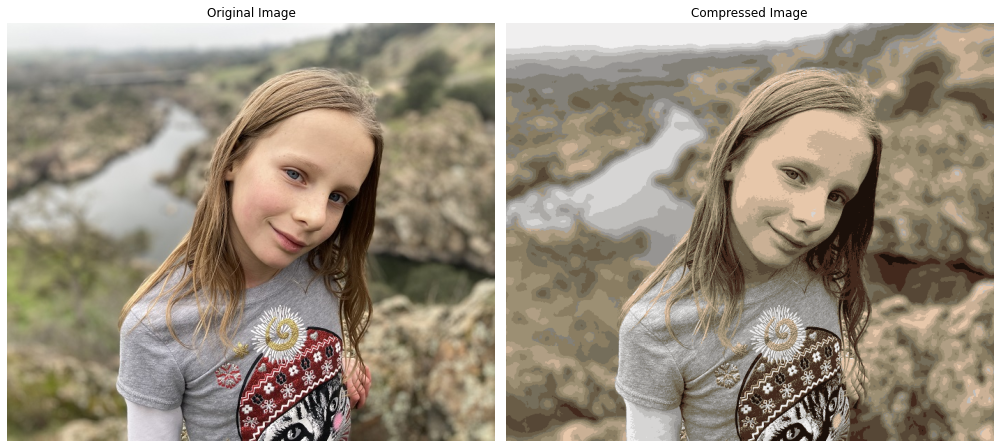

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(14,14))

ax[0].set_title('Original Image')
ax[0].imshow(img)
ax[0].axis('off')

ax[1].set_title('Compressed Image')
ax[1].imshow(cimg)
ax[1].axis('off')

plt.tight_layout()
plt.show()

## Exercise ##

Create a python module (e.g., not a jupyter notebook) that compresses an image using the KMeans Clustering Compression Algorithm described in this notebook. The compressed image that your program saves will be loaded by a second program that the instructor provides. Here are the two key functions that you will need to implement:

```
# Returns the compressed color palette and sequence of pixels that represent the compressed image
palette, pixels = convert_to_kmc(raw_image, color_count)

# Saves a compressed image using the file format described previously
# You should investigate the corresponding Load function for the exact file format (provided by instructor)
save_kmc_image(palette, pixels, dst_filename)
```

The instructor will provide you with several sample images along with a program that expands and displays compressed image files. You are encouraged to analyze the "load" program to learn about the compressed file format that we have invented. There is also skeleton code available to help with the "save" program that you have been tasked with.